## Importa funções para o pré-processamento

In [1]:
from pre_processamento import *

from dlisio import dlis
import pandas as pd
import numpy as np

# A função 'glob' do módulo 'glob' é usada para procurar todos os arquivos em um diretório com determinada extensão
import glob

## Carregamento dos dados

Para a realizar a busca por arquivos com extensão .dlis na pasta Dados-dlis, foi utilizada a função **glob()** da biblioteca glob.

A leitura dos dados é feita com a função **load()** da biblioteca dlisio.

São armazenados três tipos de dados:
* **Nome do arquivo** na lista **nomes_arquivos**

* **Dados das curvas** na lista **leituras_dlis**

* **Nome do poço** na lista **nomes_anp**

In [2]:
nomes_arquivos = []     # Armazena os nomes dos arquivos .dlis
leituras_dlis = []      # Armazena as leituras dos arquivos .dlis
nomes_anp = []          # Armazena os nomes obtidos das leituras

for file in glob.glob(r'**/Dados-dlis' + "/*.dlis", recursive=True):
    try:
        # Salva o nome do arquivo
        nomes_arquivos.append(file)

        # Salva os dados da leitura
        leitura, *tail = dlis.load(f'{file}')
        leituras_dlis.append(leitura)

        # Salva o nome do poço
        nome = leitura.origins[0].well_name
        nomes_anp.append(nome)
    except:
        pass

## Cria dicionário para armazenar os dados e respectivos nomes

In [3]:
# Casa itens da lista 'nome_anp_abreviados' com os itens da lista 'leituras_dlis'
pares = zip(nomes_anp, leituras_dlis)

# Cria dicionário 'dli_dict'
dli_dict = dict(pares)
dli_dict

{'1-FSG-1-SE': LogicalFile(AIT_SONIC_TLD_MCFL_018PUP),
 '1-FSJQ-1-SE': LogicalFile(GEOLOAD.1),
 '1-BRSA-595-SE': LogicalFile(GEOLOAD.1),
 '1-BRSA-605-SE': LogicalFile(AIT_SONIC_TLD_MCFL_048PUC),
 '1-BRSA-659-SE': LogicalFile(GEOLOAD.1),
 '1-POI-1-SE': LogicalFile(AIT_SONIC_TLD_MCFL_024PUP),
 '1-BRSA-696-SE': LogicalFile(AIT_SONIC_TLD_MCFL_003PUP),
 '1-DP-2-SE': LogicalFile(AIT_SONIC_TLD_MCFL_079PUP)}

## Separa TODAS as curvas presentes nos .dlis de cada poço
#### Para visualizar as curvas obtidas a partir da extração dos .dlis serão criados arquivos .csv com essas curvas presentes nos .dlis de cada poço.

In [4]:
channels_dict = {}

for key, poco in dli_dict.items():
    channels_list = []
    for frame in poco.frames:
        channels = frame.channels
        channels_list.append([channel.name for channel in channels])

    channels_dict[key] = sum(channels_list, [])

In [5]:
import csv

# Para cada poço no dicionário channels_dict, criar um arquivo CSV
for key, channels in channels_dict.items():
    # Definir o nome do arquivo CSV usando o identificador do poço
    filename = f'Curvas_CSV/{key}.csv'
    
    # Abrir o arquivo em modo de escrita
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Escrever o cabeçalho do CSV
        writer.writerow(['Poco', 'Channel'])
        
        # Escrever uma linha para cada canal, incluindo o nome do poço
        for channel in channels:
            writer.writerow([key, channel])

print("Arquivos CSV criados com sucesso!")

Arquivos CSV criados com sucesso!


## Concatena os arquivos CSV das curvas em um único arquivo
#### Para visualizar todas as curvas da extração dos .dlis em um único arquivo, os .csv de cada poço serão concatenados em um único arquivo .csv.

In [6]:
"""
import os

pasta = "Curvas_CSV"

# Lista para armazenar os dataframes repectivos aos .csv
df_list = []

# Itera sobre a pasta Curvas_CSV
for arquivo in os.listdir(pasta):
    file_path = os.path.join(pasta, arquivo)

    # Lê o arquivo CSV como um df
    df = pd.read_csv(file_path)
    df_list.append(df)

# Concatena os dfs ao longo do eixo das colunas
df_concat = pd.concat(df_list, axis=0, ignore_index=True)

# Salva o DF concatenado em um .csv
df_concat.to_csv("Curvas_CSV/curvas_pocos.csv", index=False)

print("Arquivo Curvas_CSV/curvas_pocos.csv criado com sucesso")
"""

'\nimport os\n\npasta = "Curvas_CSV"\n\n# Lista para armazenar os dataframes repectivos aos .csv\ndf_list = []\n\n# Itera sobre a pasta Curvas_CSV\nfor arquivo in os.listdir(pasta):\n    file_path = os.path.join(pasta, arquivo)\n\n    # Lê o arquivo CSV como um df\n    df = pd.read_csv(file_path)\n    df_list.append(df)\n\n# Concatena os dfs ao longo do eixo das colunas\ndf_concat = pd.concat(df_list, axis=0, ignore_index=True)\n\n# Salva o DF concatenado em um .csv\ndf_concat.to_csv("Curvas_CSV/curvas_pocos.csv", index=False)\n\nprint("Arquivo Curvas_CSV/curvas_pocos.csv criado com sucesso")\n'

## Curvas escolhidas
#### Cria uma lista para armazenar todas as curvas escolhidas e seus respectivos mnemônicos (alias).

In [7]:
curvas_escolhidas = ['TDEP', 'GR', 'NPHI', 'RHOB', 'RHOZ', 'DRHO', 'HDRA', 'BSZ', 'BS', 'HCAL', 'CAL', 'CALI', 'DCALI', 'DCAL', 'PE', 'PEFZ', 'PEU', 'DT', 'DTC', 'ILD', 'RILD', 'IEL', 'AIT90', 'AHT90', 'RT90', 'AT90', 'AO90', 'RT', 'AF90', 'AHF90', 'AFH90', 'LLD', 'RLLD', 'HDRS', 'HLLD', 'LL7', 'RLL7']

## Processa os 'frames' dos poços 1-BRSA-551-SE e 1-BRSA-605-SE

#### Checa a quantidade de 'frames' dos poços

In [8]:
for key, poco in dli_dict.items():
    print(f'{key}: {poco.frames}')

1-FSG-1-SE: [Frame(60B), Frame(10B), Frame(5B), Frame(30B), Frame(120B), Frame(180B), Frame(20B), Frame(1B), Frame(2B)]
1-FSJQ-1-SE: [Frame(50)]
1-BRSA-595-SE: [Frame(50)]
1-BRSA-605-SE: [Frame(60B), Frame(10B), Frame(30B), Frame(20B)]
1-BRSA-659-SE: [Frame(50)]
1-POI-1-SE: [Frame(60B), Frame(10B), Frame(5B), Frame(30B), Frame(120B), Frame(180B), Frame(20B), Frame(1B), Frame(2B)]
1-BRSA-696-SE: [Frame(60B), Frame(10B), Frame(5B), Frame(30B), Frame(120B), Frame(180B), Frame(20B), Frame(1B), Frame(2B)]
1-DP-2-SE: [Frame(60B), Frame(10B), Frame(5B), Frame(30B), Frame(120B), Frame(180B), Frame(20B), Frame(1B), Frame(2B)]


#### Cria um dicionário para armazenar os 'frames' dos poços com mais de um frame

In [9]:
frames_dict = {}

for key, poco in dli_dict.items():
    # if len(poco.frames) > 1:
    frames_dict[key] = cria_frames_dict(poco)

#### Cria um 'dataframe' para cada 'frame' dos poços com mais de um frame

In [10]:
dataframes_dict = {}

for key, poco_frames_dict in frames_dict.items():
    dataframes_dict[key] = cria_dataframes_dict(poco_frames_dict, curvas_escolhidas)

#### Salva os dataframes como arquivos (verificar onde colocar depois)

In [11]:
"""
for key, value in dataframes_dict_551.items():
    file_name = f"Frames_551/frame_{key}.csv"
    value.to_csv(file_name, index=False)
    print(f"Arquivo {file_name} criado com sucesso.")

for key, value in dataframes_dict_605.items():
    file_name = f"Frames_605/frame_{key}.csv"
    value.to_csv(file_name, index=False)
    print(f"Arquivo {file_name} criado com sucesso.")
"""

'\nfor key, value in dataframes_dict_551.items():\n    file_name = f"Frames_551/frame_{key}.csv"\n    value.to_csv(file_name, index=False)\n    print(f"Arquivo {file_name} criado com sucesso.")\n\nfor key, value in dataframes_dict_605.items():\n    file_name = f"Frames_605/frame_{key}.csv"\n    value.to_csv(file_name, index=False)\n    print(f"Arquivo {file_name} criado com sucesso.")\n'

#### Checa se todos os valores de profundidade presentes no primeiro frame existem nos demais

In [12]:
import math

def checa_TDEP(dataframes, tolerancia=0.01):
    tdep_primeiro_frame = dataframes[0]['TDEP']
  
    for key, value in dataframes.items():
        if key == 0:  # Ignorar o primeiro DataFrame
            continue
        
        tdep_outro_frame = dataframes[key]['TDEP']
        
        for valor_tdep in tdep_primeiro_frame:
            # Verifica se algum valor em tdep_outro_frame está próximo o suficiente de valor_tdep
            if any(math.isclose(valor_tdep, outro_valor, abs_tol=tolerancia) for outro_valor in tdep_outro_frame):
                print(f'{valor_tdep} - Ok')
            else:
                print(f'{valor_tdep} - Faltando')
    

#### Remove valores de profundidade que não estão presentes no primeiro frame

In [13]:
for poco_dataframes_dict in dataframes_dict.values():
    for key, value in poco_dataframes_dict.items():
        poco_dataframes_dict[key] = value[value['TDEP'].isin(poco_dataframes_dict[0]['TDEP'])]

#### Junta os dataframes dos poços em um único dataframe com as curvas escolhidas

In [14]:
for key, value in dataframes_dict.items():
    dataframes_dict[key] = unifica_dataframes(value)

#### Mantém apenas uma curva de resistividade profunda (RT)

In [15]:
for key, value in dataframes_dict.items():
    if 'RT' in value:
        dataframes_dict[key] = remove_colunas(value, ['AHT90', 'AHF90'])

## Cria dataframes para os demais poços (não é mais necessário)

In [16]:
"""
# Iterando sobre os arquivos lógicos de todos os poços (que estão armazenados em 'dli_dict'),
# '.values()' se refere aos valores do dicionário (não às chaves)
for chave, poco in dli_dict.items():

    # Armazenando as curvas que serão utilizadas em uma lista
    curvas_utilizadas = [
        channel.name                                    # Os elementos da lista serão os nomes das curvas
        for channel in poco.channels                    # As curvas são acessadas por meio de 'poco.channels'
        if channel.name in curvas_escolhidas            # As curvas que não utilizaremos não serão armazenadas na lista
    ]
    conjunto_aux = set(curvas_utilizadas)
    curvas_utilizadas_sem_duplicados = list(conjunto_aux)
    
    #frames = [np.atleast_1d(frame) for frame in poco.frames]
    #curvas = np.concatenate(frames, axis=0)
    try:
        dataframe = pd.DataFrame()
        
        for frame in poco.frames:

            curvas = frame.curves()

            dataframe = pd.concat([dataframe, pd.DataFrame(curvas[curvas_utilizadas_sem_duplicados])])

        # Criando um pandas dataframe do poço respectivo à atual iteração e armazenando o mesmo em dlis_df
        dataframes_dict[chave] = dataframe
    except:
        pass
"""

"\n# Iterando sobre os arquivos lógicos de todos os poços (que estão armazenados em 'dli_dict'),\n# '.values()' se refere aos valores do dicionário (não às chaves)\nfor chave, poco in dli_dict.items():\n\n    # Armazenando as curvas que serão utilizadas em uma lista\n    curvas_utilizadas = [\n        channel.name                                    # Os elementos da lista serão os nomes das curvas\n        for channel in poco.channels                    # As curvas são acessadas por meio de 'poco.channels'\n        if channel.name in curvas_escolhidas            # As curvas que não utilizaremos não serão armazenadas na lista\n    ]\n    conjunto_aux = set(curvas_utilizadas)\n    curvas_utilizadas_sem_duplicados = list(conjunto_aux)\n    \n    #frames = [np.atleast_1d(frame) for frame in poco.frames]\n    #curvas = np.concatenate(frames, axis=0)\n    try:\n        dataframe = pd.DataFrame()\n        \n        for frame in poco.frames:\n\n            curvas = frame.curves()\n\n          

In [17]:
dataframes_dict['1-BRSA-659-SE'] = remove_colunas(dataframes_dict['1-BRSA-659-SE'], ['PEU'])
dataframes_dict['1-FSJQ-1-SE'] = remove_colunas(dataframes_dict['1-FSJQ-1-SE'], ['PEU'])

#### Checa a unidade de medida da coluna TDEP. Se for em polegada, move a vírgula uma casa para a esquerda em todos os valores das colunas TDEP e converte a unidade de medida de polegada para metro.

In [18]:

for key, value in dataframes_dict.items():
    unidade_medida = dli_dict[key].frames[0].attic['SPACING'].units
    
    if unidade_medida == '0.1 in':
        #for value in poco_dataframes_dict.values():
        # move vírgula uma casa para a esquerda
        value['TDEP'] = value['TDEP'] / 10

        # converte de polegada para metro
        value['TDEP'] = value['TDEP'] * 0.0254


## Transforma os valores -999.25 em nulos

In [19]:
for poco in dataframes_dict.values():
    poco.replace([-999.25], [None], inplace = True)

## Aplicando os mnemônicos

In [20]:
aplica_mnemonico(dataframes_dict, ['BS', 'BSZ'], 'BS')
aplica_mnemonico(dataframes_dict, ['LLD',	'LL7',	'RLLD',	 'RLL7', 'HDRS', 'HLLD', 'ILD',	'RILD',	'IEL',	'AIT90', 'AHT90', 'RT90', 'AT90', 'AO90', 'RT', 'AF90',	'AHF90', 'AFH90'], 'RESD')
aplica_mnemonico(dataframes_dict, ['RHOB', 'RHOZ'], 'RHOB')
aplica_mnemonico(dataframes_dict, ['DTC', 'DT'], 'DT')
aplica_mnemonico(dataframes_dict, ['HCAL', 'CAL', 'CALI'], 'CAL')
aplica_mnemonico(dataframes_dict, ['DCAL', 'DCALI'], 'DCAL')
aplica_mnemonico(dataframes_dict, ['DRHO', 'HDRA'], 'DRHO')
aplica_mnemonico(dataframes_dict, ['PE', 'PEFZ', 'PEU'], 'PE')

## Adiciona coluna DCAL

In [21]:
add_DCAL(dataframes_dict)

In [22]:
for key, poco in dataframes_dict.items():
    curvas = sorted(poco.keys())
    print(f"{key}: {curvas}")

1-FSG-1-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']
1-FSJQ-1-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']
1-BRSA-595-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']
1-BRSA-605-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']
1-BRSA-659-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']
1-POI-1-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']
1-BRSA-696-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']
1-DP-2-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']


## Preenche os poços com curvas faltando (não é mais necessário)

In [23]:
'''
# Se um dos poços não tiver uma dessas curvas, adicionamos a coluna da curva e mantemos os valores como None
curvas_obrigatorias = ['TDEP', 'BS', 'CAL', 'DCAL', 'GR', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE']

# Percorre todos os poços
for poco in dataframes_dict.values():
    # Percorre todas as curvas obrigatórias
    for curva in curvas_obrigatorias:
        # Se o poço não tiver a curva
        if curva not in poco.columns:
            # Adiciona a coluna e os valores dela = None
            poco[curva] = None
'''

"\n# Se um dos poços não tiver uma dessas curvas, adicionamos a coluna da curva e mantemos os valores como None\ncurvas_obrigatorias = ['TDEP', 'BS', 'CAL', 'DCAL', 'GR', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE']\n\n# Percorre todos os poços\nfor poco in dataframes_dict.values():\n    # Percorre todas as curvas obrigatórias\n    for curva in curvas_obrigatorias:\n        # Se o poço não tiver a curva\n        if curva not in poco.columns:\n            # Adiciona a coluna e os valores dela = None\n            poco[curva] = None\n"

## Temos as seguintes curvas 

In [24]:
for key, poco in dataframes_dict.items():
    curvas = sorted(poco.keys())
    print(f"{key}: {curvas}")

1-FSG-1-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']
1-FSJQ-1-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']
1-BRSA-595-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']
1-BRSA-605-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']
1-BRSA-659-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']
1-POI-1-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']
1-BRSA-696-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']
1-DP-2-SE: ['BS', 'CAL', 'DCAL', 'DRHO', 'DT', 'GR', 'NPHI', 'PE', 'RESD', 'RHOB', 'TDEP']


## Remove valores DRHO e DCAL indesejados (Só depois)

In [25]:
#limita_curva(dataframes_dict, "DRHO", -0.15, 0.15)
#limita_curva(dataframes_dict, "DCAL", -2, 2)

## Inverte a ordem das linhas dos dataframes

In [26]:
for key in dataframes_dict.keys():
    dataframes_dict[key] = dataframes_dict[key].iloc[::-1].reset_index(drop=True)

## Ordena as colunas dos dataframes

In [27]:
# Simon e Vandelli já definiram (maio/24)
ordem_desejada = ['TDEP', 'BS', 'CAL', 'DCAL', 'GR', 'RESD', 'DT', 'RHOB', 'DRHO', 'NPHI', 'PE']

for key in dataframes_dict.keys():
    try:
        dataframes_dict[key] = dataframes_dict[key].reindex(columns=ordem_desejada)
    except:
        pass

## Salva os dados dos dataframes em arquivos CSV

In [28]:
for key, value in dataframes_dict.items():
    file_name = f"Pocos-pre-processados/poco_{key}.csv"
    value.to_csv(file_name, index=False)
    print(f"Arquivo {file_name} criado com sucesso.")

Arquivo Pocos-pre-processados/poco_1-FSG-1-SE.csv criado com sucesso.
Arquivo Pocos-pre-processados/poco_1-FSJQ-1-SE.csv criado com sucesso.
Arquivo Pocos-pre-processados/poco_1-BRSA-595-SE.csv criado com sucesso.
Arquivo Pocos-pre-processados/poco_1-BRSA-605-SE.csv criado com sucesso.
Arquivo Pocos-pre-processados/poco_1-BRSA-659-SE.csv criado com sucesso.
Arquivo Pocos-pre-processados/poco_1-POI-1-SE.csv criado com sucesso.
Arquivo Pocos-pre-processados/poco_1-BRSA-696-SE.csv criado com sucesso.
Arquivo Pocos-pre-processados/poco_1-DP-2-SE.csv criado com sucesso.


In [29]:
"""
for key, value in dataframes_dict.items():
    file_name = f"Pocos-pre-processados-sem-conversao/poco_{key}.csv"
    value.to_csv(file_name, index=False)
    print(f"Arquivo {file_name} criado com sucesso.")
"""

'\nfor key, value in dataframes_dict.items():\n    file_name = f"Pocos-pre-processados-sem-conversao/poco_{key}.csv"\n    value.to_csv(file_name, index=False)\n    print(f"Arquivo {file_name} criado com sucesso.")\n'

## Análise das anomalias

#### Anidrita nos poços P_595 e P_605

In [43]:
# Arredonda TDEP do P_595 e do P_605
dataframes_dict['1-BRSA-595-SE']['TDEP'] = dataframes_dict['1-BRSA-595-SE']['TDEP'].round(1)
dataframes_dict['1-BRSA-605-SE']['TDEP'] = dataframes_dict['1-BRSA-605-SE']['TDEP'].round(1)

In [44]:
# Separa as curvas de interesse nos dados da extração dos .dlis
tdep_gr = ['TDEP', 'GR']
dlis_595 = dataframes_dict['1-BRSA-595-SE'][tdep_gr]
dlis_605 = dataframes_dict['1-BRSA-605-SE'][tdep_gr]

In [45]:
fusao_595 = pd.read_csv('arquivos-secundarios/merged_1-BRSA-595-SE.csv')
fusao_605 = pd.read_csv('arquivos-secundarios/merged_1-BRSA-605-SE.csv')

In [46]:
# Separa as curvas de interesse nos dados da fusão
profundidade_litologia_gr = ['Poço', 'Profundidade', 'Litologia', 'GR']
fusao_595 = fusao_595[profundidade_litologia_gr]
fusao_605 = fusao_605[profundidade_litologia_gr]

In [47]:
fusao_595 = pd.merge(fusao_595, dlis_595, left_on='Profundidade', right_on='TDEP')
fusao_605 = pd.merge(fusao_605, dlis_605, left_on='Profundidade', right_on='TDEP')

In [48]:
renomeia_coluna(fusao_595, 'GR_x', 'GR_fusão')
renomeia_coluna(fusao_595, 'GR_y', 'GR_dlis')

renomeia_coluna(fusao_605, 'GR_x', 'GR_fusão')
renomeia_coluna(fusao_605, 'GR_y', 'GR_dlis')

In [50]:
renomeia_coluna(fusao_595, 'Profundidade', 'Profundidade (fusão)')
renomeia_coluna(fusao_595, 'TDEP', 'TDEP (dlis)')

renomeia_coluna(fusao_605, 'Profundidade', 'Profundidade (fusão)')
renomeia_coluna(fusao_605, 'TDEP', 'TDEP (dlis)')

In [51]:
fusao_595 = fusao_595.reindex(columns=['Poço', 'Litologia', 'Profundidade (fusão)', 'TDEP (dlis)', 'GR_fusão', 'GR_dlis'])
fusao_605 = fusao_605.reindex(columns=['Poço', 'Litologia', 'Profundidade (fusão)', 'TDEP (dlis)', 'GR_fusão', 'GR_dlis'])

In [52]:
fusao_595 = fusao_595[fusao_595['Litologia'] == 'ANIDRITA']
fusao_605 = fusao_605[fusao_605['Litologia'] == 'ANIDRITA']

In [53]:
fusao_595

,Poço,Litologia,Profundidade (fusão),TDEP (dlis),GR_fusão,GR_dlis
4760,1-BRSA-595-SE,ANIDRITA,506.0,506.0,80.870857,80.870857
4761,1-BRSA-595-SE,ANIDRITA,506.1,506.1,75.696465,75.696465
4762,1-BRSA-595-SE,ANIDRITA,506.2,506.2,68.037285,68.037285
4763,1-BRSA-595-SE,ANIDRITA,506.3,506.3,58.621700,58.6217
4764,1-BRSA-595-SE,ANIDRITA,506.4,506.4,49.005054,49.005054
...,...,...,...,...,...,...
5455,1-BRSA-595-SE,ANIDRITA,575.5,575.5,46.489933,46.489933
5456,1-BRSA-595-SE,ANIDRITA,575.6,575.6,48.212200,48.2122
5457,1-BRSA-595-SE,ANIDRITA,575.7,575.7,48.485336,48.485336
5458,1-BRSA-595-SE,ANIDRITA,575.8,575.8,48.955738,48.955738


In [54]:
fusao_605

,Poço,Litologia,Profundidade (fusão),TDEP (dlis),GR_fusão,GR_dlis
568,1-BRSA-605-SE,ANIDRITA,459.0,459.0,50.378628,50.378628
569,1-BRSA-605-SE,ANIDRITA,459.5,459.5,52.740740,52.740742
597,1-BRSA-605-SE,ANIDRITA,481.0,481.0,24.169436,24.169436
598,1-BRSA-605-SE,ANIDRITA,482.0,482.0,27.013620,27.013620
599,1-BRSA-605-SE,ANIDRITA,482.5,482.5,23.636969,23.636969
601,1-BRSA-605-SE,ANIDRITA,484.0,484.0,62.256520,62.256519
602,1-BRSA-605-SE,ANIDRITA,484.5,484.5,27.865974,27.865974
603,1-BRSA-605-SE,ANIDRITA,485.5,485.5,21.722290,21.722290
604,1-BRSA-605-SE,ANIDRITA,486.0,486.0,24.484602,24.484602
605,1-BRSA-605-SE,ANIDRITA,486.5,486.5,23.354660,23.354660


In [55]:
calcular_diferenca(fusao_595, 'GR_fusão', 'GR_dlis', 'Diferença GR')
calcular_diferenca(fusao_605, 'GR_fusão', 'GR_dlis', 'Diferença GR')

,Poço,Litologia,Profundidade (fusão),TDEP (dlis),GR_fusão,GR_dlis,Diferença GR
568,1-BRSA-605-SE,ANIDRITA,459.0,459.0,50.378628,50.378628,2.229004e-07
569,1-BRSA-605-SE,ANIDRITA,459.5,459.5,52.740740,52.740742,-1.729736e-06
597,1-BRSA-605-SE,ANIDRITA,481.0,481.0,24.169436,24.169436,4.989014e-07
598,1-BRSA-605-SE,ANIDRITA,482.0,482.0,27.013620,27.013620,-3.765869e-07
599,1-BRSA-605-SE,ANIDRITA,482.5,482.5,23.636969,23.636969,3.873291e-07
601,1-BRSA-605-SE,ANIDRITA,484.0,484.0,62.256520,62.256519,6.823730e-07
602,1-BRSA-605-SE,ANIDRITA,484.5,484.5,27.865974,27.865974,-4.262695e-07
603,1-BRSA-605-SE,ANIDRITA,485.5,485.5,21.722290,21.722290,-3.906250e-08
604,1-BRSA-605-SE,ANIDRITA,486.0,486.0,24.484602,24.484602,2.551269e-08
605,1-BRSA-605-SE,ANIDRITA,486.5,486.5,23.354660,23.354660,-3.417969e-08


In [56]:
teste_gr_anidrita_595 = fusao_595.to_csv('test_gr_anidrita_595.csv', index=False)
teste_gr_anidrita_605 = fusao_605.to_csv('test_gr_anidrita_605.csv', index=False)

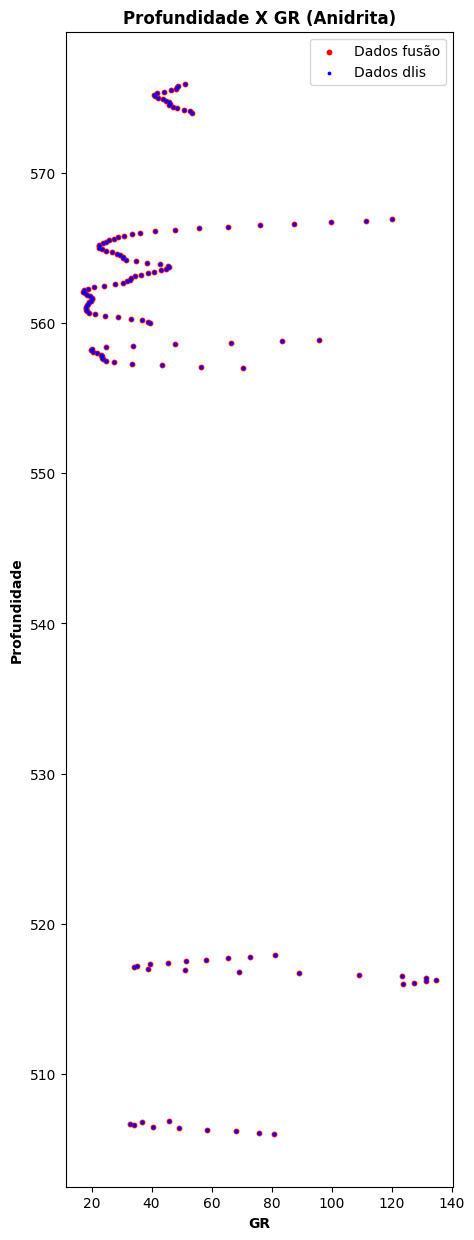

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,15))
plt.scatter(fusao_595['GR_fusão'], fusao_595['Profundidade (fusão)'], label='Dados fusão', color='red', s=10)
plt.scatter(fusao_595['GR_dlis'], fusao_595['TDEP (dlis)'], label='Dados dlis',color='blue', s=3)
plt.title('Profundidade X GR (Anidrita)', fontweight='bold')
plt.xlabel('GR', fontweight='bold')
plt.ylabel('Profundidade', fontweight='bold')
plt.legend()

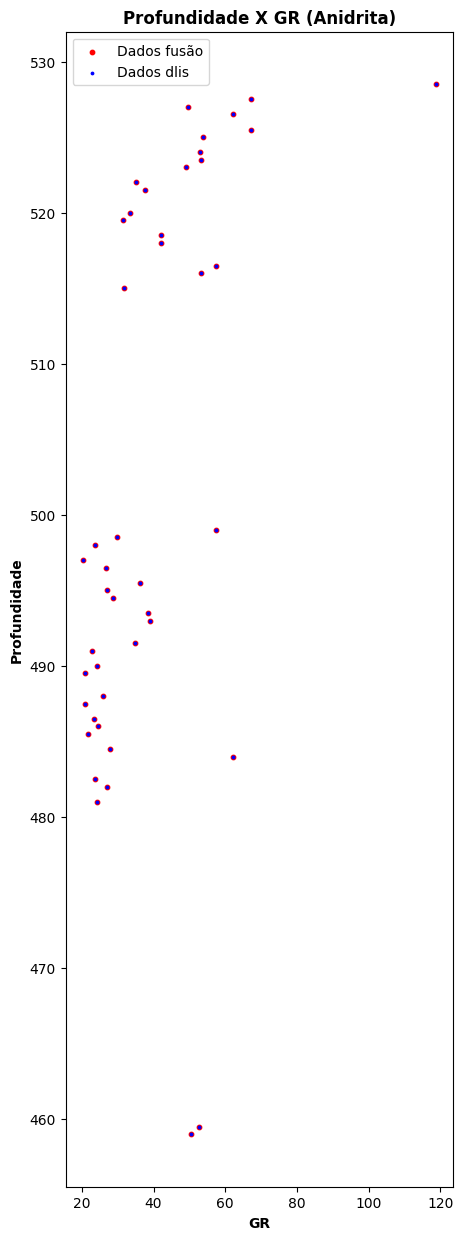

In [57]:
plt.figure(figsize=(5,15))
plt.scatter(fusao_605['GR_fusão'], fusao_605['Profundidade (fusão)'], label='Dados fusão', color='red', s=10)
plt.scatter(fusao_605['GR_dlis'], fusao_605['TDEP (dlis)'], label='Dados dlis',color='blue', s=3)
plt.title('Profundidade X GR (Anidrita)', fontweight='bold')
plt.xlabel('GR', fontweight='bold')
plt.ylabel('Profundidade', fontweight='bold')
plt.legend()